# 1. import libraries

In [1]:
# data manipulation and plotting tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data processing
! pip install category_encoders
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
import category_encoders as ce



# explainability
!pip install shap
!pip install seaborn
import shap
import seaborn as sns


# 2. Load the dataset

In [28]:
data = pd.read_csv('churn.csv')

In [30]:
data.columns

Index(['Customer ID', 'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married',
       'Dependents', 'Number of Dependents', 'Country', 'State', 'City',
       'Zip Code', 'Latitude', 'Longitude', 'Population', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Customer Status', 'Churn Label',
       'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason'],
      dtype='object')

### Exploracion de Datos

In [31]:
data.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Population                              0
Quarter                                 0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

In [32]:
data['Internet Type'].value_counts(dropna=False)

Internet Type
Fiber Optic    3035
DSL            1652
NaN            1526
Cable           830
Name: count, dtype: int64

In [33]:
data['Number of Referrals'].value_counts()

Number of Referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
2      236
4      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64

In [34]:
data['Referred a Friend'].value_counts()

Referred a Friend
No     3821
Yes    3222
Name: count, dtype: int64

In [35]:
data['Offer'].value_counts()

Offer
Offer B    824
Offer E    805
Offer D    602
Offer A    520
Offer C    415
Name: count, dtype: int64

In [36]:
data['Quarter'].value_counts()

Quarter
Q3    7043
Name: count, dtype: int64

In [37]:
data['City'].value_counts()

City
Los Angeles         293
San Diego           285
San Jose            112
Sacramento          108
San Francisco       104
                   ... 
Jacumba               2
South Lake Tahoe      2
Johannesburg          2
Eldridge              2
Holtville             2
Name: count, Length: 1106, dtype: int64

In [38]:
data['State'].value_counts()

State
California    7043
Name: count, dtype: int64

In [39]:
data['Country'].value_counts()

Country
United States    7043
Name: count, dtype: int64

In [40]:
data['Dependents'].value_counts()

Dependents
No     5416
Yes    1627
Name: count, dtype: int64

In [41]:
data['Number of Dependents'].value_counts()

Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
8       1
9       1
Name: count, dtype: int64

In [42]:
data['Age'].value_counts()

Age
42    156
47    153
40    150
44    148
23    146
     ... 
80     66
66     63
78     63
67     61
72     58
Name: count, Length: 62, dtype: int64

In [43]:
data['Under 30'].value_counts()

Under 30
No     5642
Yes    1401
Name: count, dtype: int64

In [44]:
data['Device Protection Plan'].value_counts()

Device Protection Plan
No     4621
Yes    2422
Name: count, dtype: int64

Las variables que se excluyeron fueron las siguientes:

*   Zip Code porque no es pertinente para el caso de estudio sobre la tasa de abandono del servicio.
*  Longitude no se necesita para la variable predicción churn.
*  Population no se busca proyectar la población por codigo postal.
*  Customer ID se elimina esta columna ya que su codificación atrasaria al modelo para que realice las predicciones porque son muchos clientes.
* Country y State no hay diferencias significativas en el servicio entre estados o países.
*   Quarter porque todos los clientes tienen el mismo trimestre del año que es el tercero.





















In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

En la variable Offer existe una categoría llamada 'None' la cual no aparece en la data a pesar de que se especifica que forma parte en el diccionario de la misma, por lo que se asume que 'None' representa los valores nulos de este feature.
Y se procede a reemplazar "None" en los nulos.

#### Limpieza de datos

In [46]:
#Funcion para eliminar nulos
def replace_none(col):
  if pd.isnull(col):
    return 'No'
  else:
    return col


In [47]:
data['Offer']= data.apply(lambda x: replace_none(x['Offer']), axis=1)
data['Internet Type']= data.apply(lambda x: replace_none(x['Internet Type']), axis=1)

In [48]:
data['Offer'].value_counts(), data['Internet Type'].value_counts()

(Offer
 No         3877
 Offer B     824
 Offer E     805
 Offer D     602
 Offer A     520
 Offer C     415
 Name: count, dtype: int64,
 Internet Type
 Fiber Optic    3035
 DSL            1652
 No             1526
 Cable           830
 Name: count, dtype: int64)

Como se observa en el código de abajo se solucionó el problema de los nulos y los únicos valores que quedaron con nulos son aquellos que no se incluyeron para el estudio por parte de la misma data.

In [49]:
data.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Population                              0
Quarter                                 0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

Ahora se eliminan todas las columnas que no son pertinentes para el caso de estudio.

In [50]:
data= data.drop(columns=['Zip Code','Longitude','Population','Customer ID','Country','State',
                         'Quarter','Customer Status','Churn Score','Churn Category','Churn Reason','City'])

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Under 30                           7043 non-null   object 
 3   Senior Citizen                     7043 non-null   object 
 4   Married                            7043 non-null   object 
 5   Dependents                         7043 non-null   object 
 6   Number of Dependents               7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Referred a Friend                  7043 non-null   object 
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

# 3. Data Splitting

In [52]:
train_data, tmp_data = train_test_split(data, test_size=0.3, stratify=data["Churn Label"], random_state=42)
val_data, test_data = train_test_split(tmp_data, stratify=tmp_data["Churn Label"], test_size=0.50, random_state=42)

# 4. Exploratory Data Analysis

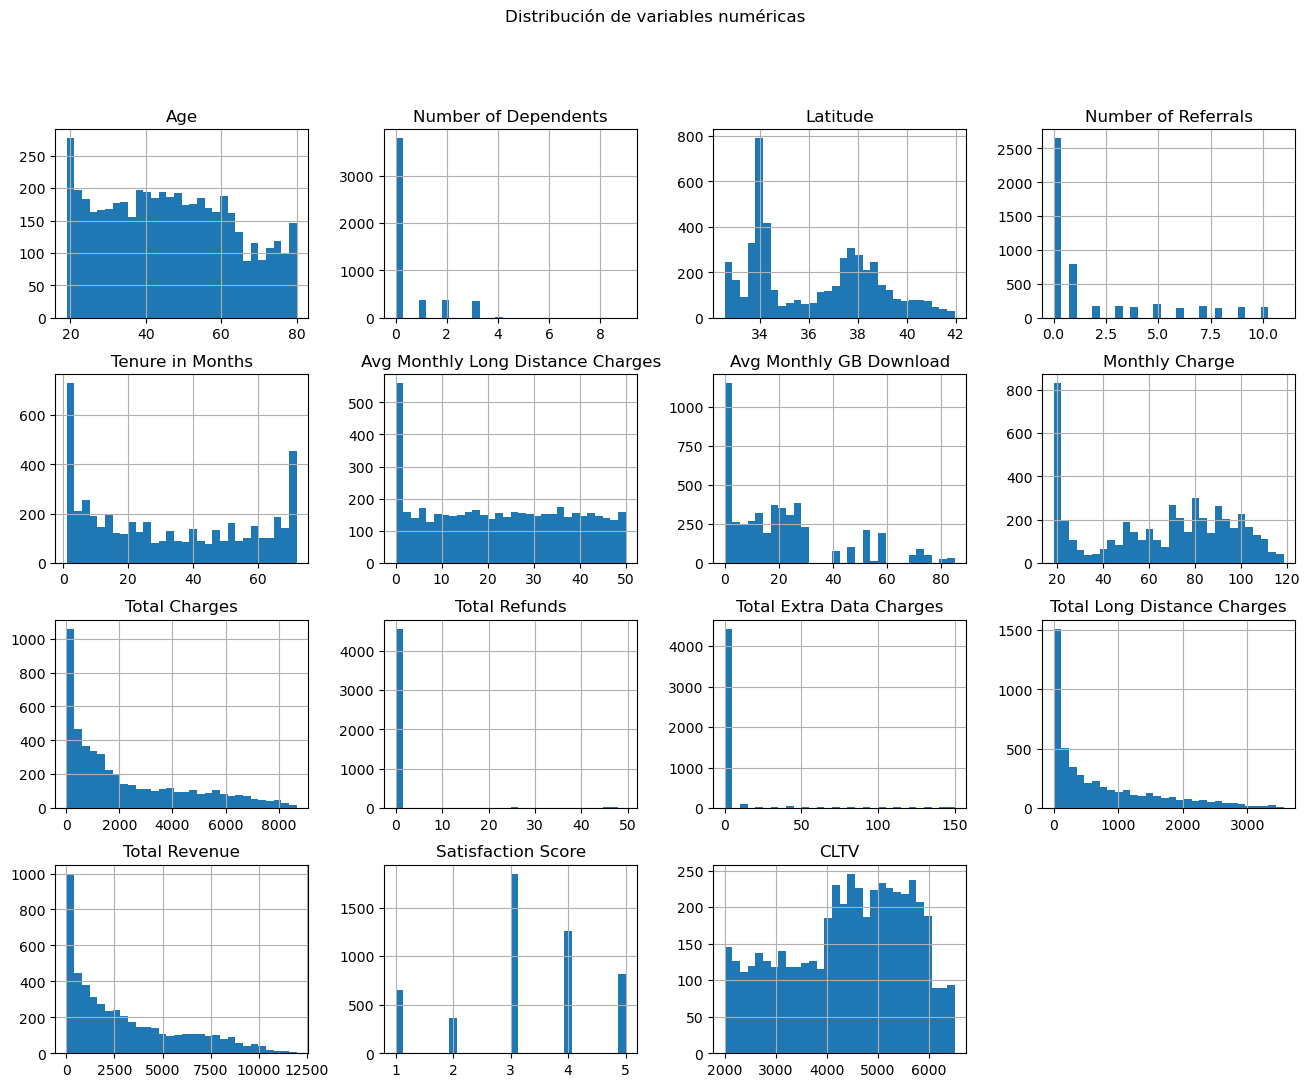

In [53]:
train_data.hist(figsize=(16,12), bins=30)
plt.suptitle("Distribución de variables numéricas")
plt.show()

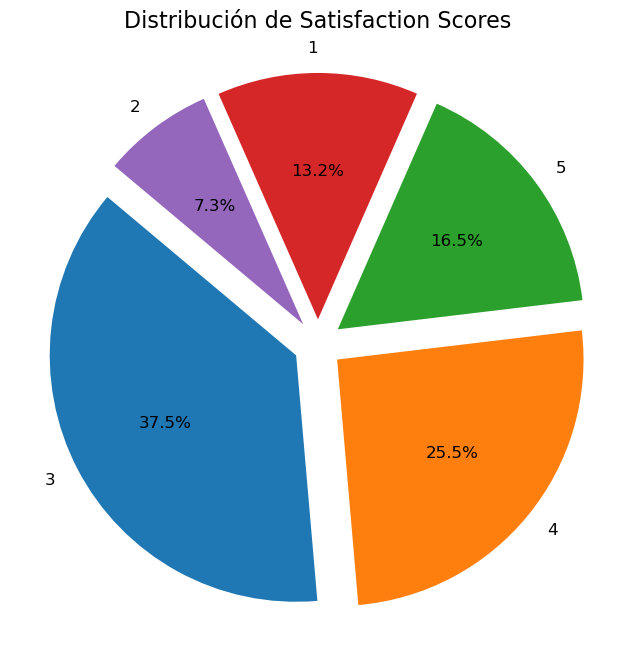

In [54]:
satisfaction_counts = train_data['Satisfaction Score'].value_counts()
percentages = (satisfaction_counts / satisfaction_counts.sum()) * 100

# Crear lista de separación para las secciones (ajustar los valores para cada sección)
explode = [0.1] * len(percentages)  # Separa todas las secciones del gráfico para evitar superposiciones

# Crear gráfico de pastel con ajustes para mejorar visibilidad
plt.figure(figsize=(10, 8))  # Aumentar tamaño del gráfico
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%',
        startangle=140, explode=explode, textprops={'fontsize': 12})  # Cambiar tamaño de fuente
plt.title('Distribución de Satisfaction Scores', fontsize=16)  # Aumentar tamaño del título
plt.show()

In [55]:
train_data["Number of Dependents"].value_counts()

Number of Dependents
0    3791
2     384
1     368
3     365
4       9
5       7
7       2
6       2
8       1
9       1
Name: count, dtype: int64

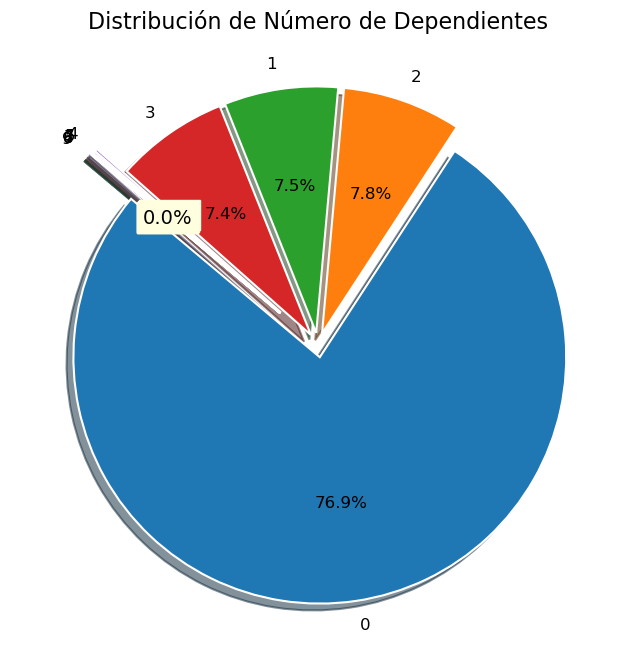

In [56]:
# Calcular la frecuencia y el porcentaje de la columna 'Number of Dependents'
Referidos_counts = train_data["Number of Dependents"].value_counts()
percentages = (Referidos_counts / Referidos_counts.sum()) * 100

# Crear lista de separación para las secciones (resaltar los valores pequeños con mayor separación)
explode = [0.2 if pct < 5 else 0.05 for pct in percentages]  # Aumentar separación para valores < 5%

# Crear gráfico de pastel con ajustes para mejorar la visibilidad
plt.figure(figsize=(10, 8))  # Aumentar tamaño del gráfico
patches, texts, autotexts = plt.pie(
    percentages,
    labels=percentages.index,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',  # Omitir 0% en etiquetas
    startangle=140,
    explode=explode,
    textprops={'fontsize': 12},
    shadow=True,
    wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}
)

# Ajustar las propiedades de las etiquetas para mejorar visibilidad de valores pequeños
for text in autotexts:
    text.set_color('black')  # Establecer color de texto
    if text.get_text() and float(text.get_text().strip('%')) < 5:
        text.set_fontsize(14)  # Aumentar el tamaño de la fuente para valores < 5%
        text.set_backgroundcolor('lightyellow')  # Agregar fondo para resaltar

# Título del gráfico
plt.title('Distribución de Número de Dependientes', fontsize=16)
plt.show()


Como el porcentaje es mas abajo de cero para la grafica anterior se procedio a filtrar la información para que solo aquellos numeros de dependientes con más porcentajes se incluyeran en el pie chart.

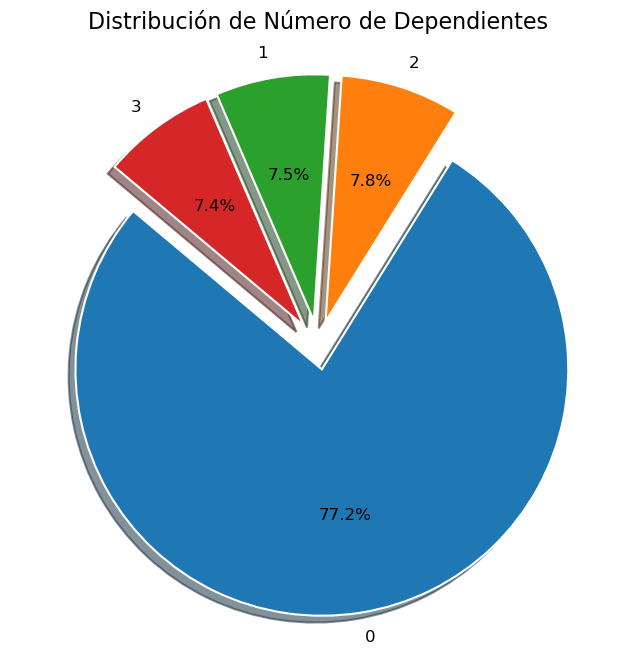

In [57]:
# Filtrar sólo los valores de dependientes 0, 1, 2 y 3
filtered_counts = Referidos_counts[Referidos_counts.index.isin([0, 1, 2, 3])]
percentages = (filtered_counts / filtered_counts.sum()) * 100

# Crear lista de separación para las secciones
explode = [0.1] * len(percentages)  # Separar todas las secciones

# Crear gráfico de pastel con ajustes para mejorar visibilidad
plt.figure(figsize=(10, 8))  # Aumentar tamaño del gráfico
patches, texts, autotexts = plt.pie(
    percentages,
    labels=percentages.index,
    autopct='%1.1f%%',  # Mostrar porcentaje con un decimal
    startangle=140,
    explode=explode,
    textprops={'fontsize': 12},
    shadow=True,
    wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}
)

# Ajustar las propiedades de las etiquetas para mejorar visibilidad
for text in autotexts:
    text.set_color('black')  # Establecer color de texto

# Título del gráfico
plt.title('Distribución de Número de Dependientes', fontsize=16)
plt.show()

In [58]:
train_data.groupby("Senior Citizen")["Churn Label"].value_counts(normalize=True)

Senior Citizen  Churn Label
No              No             0.763676
                Yes            0.236324
Yes             No             0.588739
                Yes            0.411261
Name: proportion, dtype: float64

In [59]:
train_data.groupby("Married")["Churn Label"].value_counts(normalize=True)

Married  Churn Label
No       No             0.676145
         Yes            0.323855
Yes      No             0.796497
         Yes            0.203503
Name: proportion, dtype: float64

In [60]:
train_data.groupby("Dependents")["Churn Label"].value_counts(normalize=True)

Dependents  Churn Label
No          No             0.675547
            Yes            0.324453
Yes         No             0.931519
            Yes            0.068481
Name: proportion, dtype: float64

In [61]:
train_data.groupby("Referred a Friend")["Churn Label"].value_counts(normalize=True)

Referred a Friend  Churn Label
No                 No             0.678113
                   Yes            0.321887
Yes                No             0.800439
                   Yes            0.199561
Name: proportion, dtype: float64

In [62]:
train_data.groupby("Tenure in Months")["Churn Label"].value_counts(normalize=True)

Tenure in Months  Churn Label
1                 Yes            0.618483
                  No             0.381517
2                 Yes            0.530488
                  No             0.469512
3                 No             0.552448
                                   ...   
70                Yes            0.118421
71                No             0.950000
                  Yes            0.050000
72                No             0.980769
                  Yes            0.019231
Name: proportion, Length: 144, dtype: float64

In [63]:
train_data.groupby("Offer")["Churn Label"].value_counts(normalize=True)

Offer    Churn Label
No       No             0.728651
         Yes            0.271349
Offer A  No             0.921569
         Yes            0.078431
Offer B  No             0.860781
         Yes            0.139219
Offer C  No             0.797251
         Yes            0.202749
Offer D  No             0.741860
         Yes            0.258140
Offer E  Yes            0.526882
         No             0.473118
Name: proportion, dtype: float64

In [64]:
train_data.groupby("Payment Method")["Churn Label"].value_counts(normalize=True)

Payment Method   Churn Label
Bank Withdrawal  No             0.660857
                 Yes            0.339143
Credit Card      No             0.854068
                 Yes            0.145932
Mailed Check     No             0.645756
                 Yes            0.354244
Name: proportion, dtype: float64

In [65]:
train_data.groupby("Satisfaction Score")["Churn Label"].value_counts(normalize=True)

Satisfaction Score  Churn Label
1                   Yes            1.000000
2                   Yes            1.000000
3                   No             0.838203
                    Yes            0.161797
4                   No             1.000000
5                   No             1.000000
Name: proportion, dtype: float64

In [66]:
train_data.groupby("Internet Type")["Churn Label"].value_counts(normalize=True)

Internet Type  Churn Label
Cable          No             0.737589
               Yes            0.262411
DSL            No             0.816102
               Yes            0.183898
Fiber Optic    No             0.591403
               Yes            0.408597
No             No             0.927035
               Yes            0.072965
Name: proportion, dtype: float64

In [67]:
train_data.groupby("Online Security")["Churn Label"].value_counts(normalize=True)

Online Security  Churn Label
No               No             0.687376
                 Yes            0.312624
Yes              No             0.855292
                 Yes            0.144708
Name: proportion, dtype: float64

In [68]:
train_data.groupby("Contract")["Churn Label"].value_counts(normalize=True)

Contract        Churn Label
Month-to-Month  No             0.543220
                Yes            0.456780
One Year        No             0.889908
                Yes            0.110092
Two Year        No             0.972686
                Yes            0.027314
Name: proportion, dtype: float64

In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4930 entries, 5963 to 6017
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4930 non-null   object 
 1   Age                                4930 non-null   int64  
 2   Under 30                           4930 non-null   object 
 3   Senior Citizen                     4930 non-null   object 
 4   Married                            4930 non-null   object 
 5   Dependents                         4930 non-null   object 
 6   Number of Dependents               4930 non-null   int64  
 7   Latitude                           4930 non-null   float64
 8   Referred a Friend                  4930 non-null   object 
 9   Number of Referrals                4930 non-null   int64  
 10  Tenure in Months                   4930 non-null   int64  
 11  Offer                              4930 non-null   object 

In [70]:
ed_emp_types = train_data.groupby(["Married", "Dependents"])["Churn Label"].value_counts(normalize=True)

In [71]:
ed_emp_types = ed_emp_types.reset_index()

In [72]:
ed_emp_types.head()

,Married,Dependents,Churn Label,proportion
0,No,No,No,0.661499
1,No,No,Yes,0.338501
2,No,Yes,No,0.838095
3,No,Yes,Yes,0.161905
4,Yes,No,No,0.697754


In [73]:
ed_emp_types[ed_emp_types["Churn Label"] == "Yes"].set_index(["Married", "Dependents"])

Churn Label  proportion
Married Dependents                        
No      No                 Yes    0.338501
        Yes                Yes    0.161905
Yes     No                 Yes    0.302246
        Yes                Yes    0.047363

In [74]:
test_data.groupby("Churn Label")["Satisfaction Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn Label,,,,,,,,
No,776.0,3.750000,0.766643,3.0,3.0,4.0,4.0,5.0
Yes,281.0,1.782918,0.805690,1.0,1.0,2.0,2.0,3.0


<Axes: xlabel='Churn Label', ylabel='Satisfaction Score'>

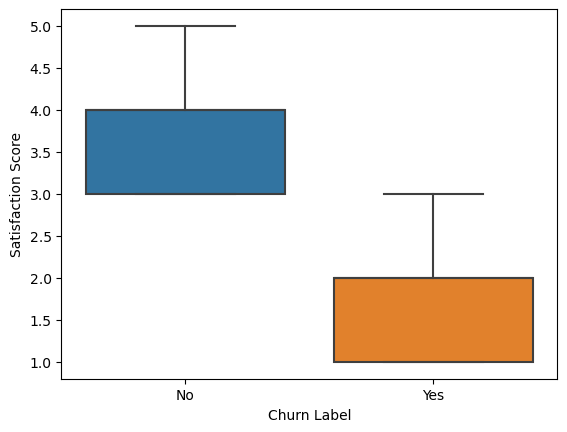

In [75]:
sns.boxplot(x="Churn Label", y="Satisfaction Score", data=train_data)

In [76]:
#correlacion solo entre las variables numericas

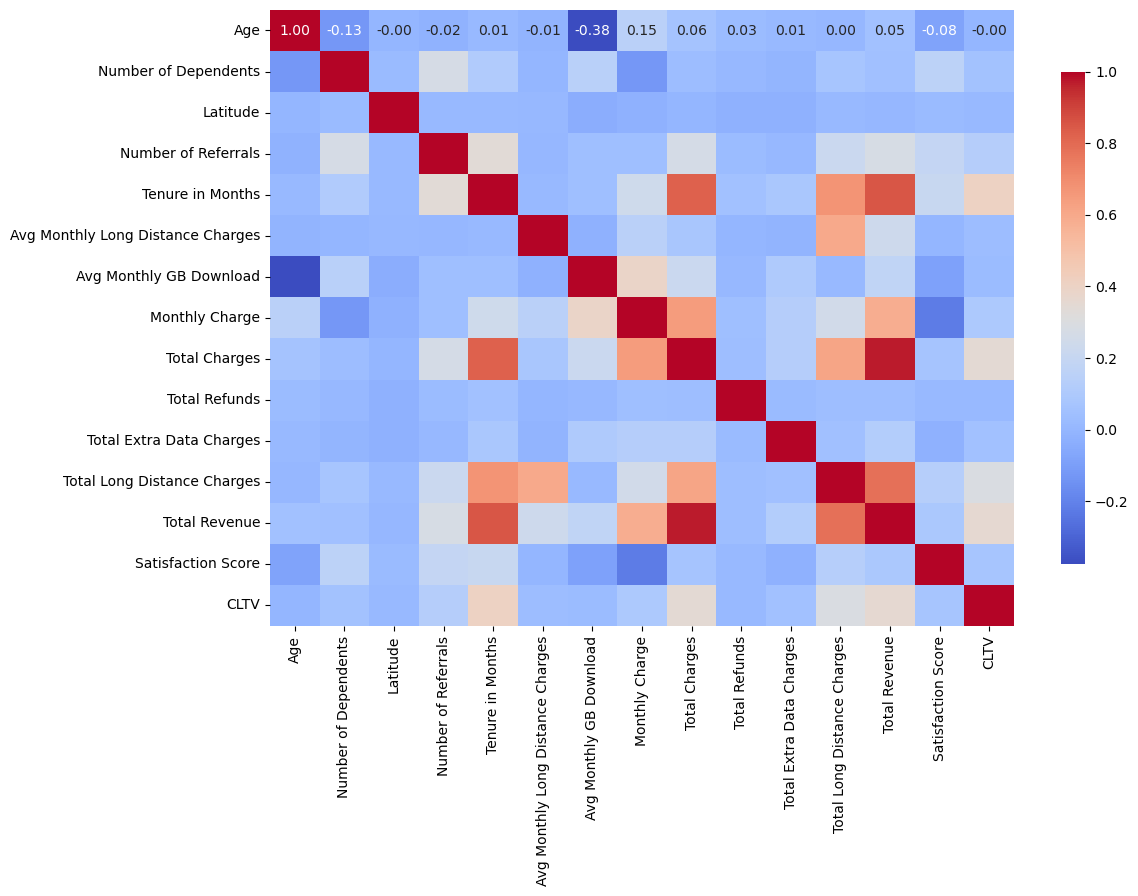

In [77]:
# Ajustar el tamaño de la figura para que sea más grande
plt.figure(figsize=(12, 8))

# Crear el heatmap con ajustes en el tamaño de la fuente y formato de anotaciones
sns.heatmap(train_data.corr(numeric_only=True), annot=True, fmt='.2f',
            cmap='coolwarm', annot_kws={"size": 10}, cbar_kws={'shrink': 0.8})

# Mostrar el heatmap
plt.show()

In [78]:
correlation = data['Total Charges'].corr(data['Total Long Distance Charges'])
print(correlation)

0.6101851906103251


In [79]:
# Your code here. Exploratory data analysis can be done before splitting, but do not transform the dataset before splitting.

#### Limpieza de datos

In [80]:
#Funcion para eliminar nulos
def replace_none(col):
  if pd.isnull(col):
    return 'No'
  else:
    return col


In [81]:
data['Offer']= data.apply(lambda x: replace_none(x['Offer']), axis=1)
data['Internet Type']= data.apply(lambda x: replace_none(x['Internet Type']), axis=1)

In [82]:
data['Offer'].value_counts(), data['Internet Type'].value_counts()

(Offer
 No         3877
 Offer B     824
 Offer E     805
 Offer D     602
 Offer A     520
 Offer C     415
 Name: count, dtype: int64,
 Internet Type
 Fiber Optic    3035
 DSL            1652
 No             1526
 Cable           830
 Name: count, dtype: int64)

Como se observa en el código de abajo se solucionó el problema de los nulos y los únicos valores que quedaron con nulos son aquellos que no se incluyeron para el estudio por parte de la misma data.

In [83]:
data.isnull().sum()

Gender                               0
Age                                  0
Under 30                             0
Senior Citizen                       0
Married                              0
Dependents                           0
Number of Dependents                 0
Latitude                             0
Referred a Friend                    0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

Ahora se eliminan todas las columnas que no son pertinentes para el caso de estudio.

In [84]:
#data = data.drop(columns=['Zip Code','Longitude','Population','Customer ID','Country','State',
                        # 'Quarter','Customer Status','Churn Score','Churn Category','Churn Reason','City'])

In [85]:
# Your code here. Exploratory data analysis can be done before splitting, but do not transform the dataset before splitting.

# 5. Data Processing

## Feature Engineering

In [86]:
def assign_region_within_california(lat):
    if lat > 38:
        return "Norte de California"
    elif 36 <= lat <= 38:
        return "Centro de California"
    else:
        return "Sur de California"
def crear_features(df):
    df["Extra Charges Ratio"] = df['Total Extra Data Charges'] / df['Total Charges']
    df["Has Streaming Service"] = df[['Streaming TV', 'Streaming Movies', 'Streaming Music']].apply(
    lambda x: 1 if any(service == 'Yes' for service in x) else 0, axis=1)
    df['Region_CA'] =  df['Latitude'].apply(assign_region_within_california)
    return df

In [87]:
crear_features(train_data)
crear_features(val_data)
crear_features(test_data)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Latitude,Referred a Friend,Number of Referrals,...,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Label,CLTV,Extra Charges Ratio,Has Streaming Service,Region_CA
430,Male,65,No,Yes,No,No,0,38.470423,No,0,...,0.0,0,41.98,223.68,1,Yes,5569,0.0,1,Norte de California
4651,Female,46,No,No,Yes,No,0,40.294034,No,0,...,0.0,0,204.54,496.94,3,No,4556,0.0,0,Norte de California
1082,Male,76,No,Yes,Yes,No,0,38.695490,Yes,4,...,0.0,0,0.00,1364.75,3,No,4691,0.0,0,Norte de California
4027,Male,24,Yes,No,No,No,0,36.141319,No,0,...,0.0,0,206.45,480.80,3,No,2612,0.0,0,Centro de California
5845,Male,31,No,No,Yes,No,0,34.209532,Yes,9,...,0.0,0,1978.60,8326.15,4,No,6300,0.0,1,Sur de California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6874,Male,63,No,No,No,No,0,34.196837,No,0,...,0.0,0,1537.92,2453.92,5,No,3779,0.0,0,Sur de California
3920,Female,52,No,No,No,No,0,33.761894,No,0,...,0.0,0,614.55,983.65,5,No,5218,0.0,0,Sur de California
6178,Male,46,No,No,Yes,No,0,34.936000,Yes,5,...,0.0,0,518.80,3651.55,3,No,3387,0.0,0,Sur de California
5895,Female,37,No,No,No,No,0,34.231318,No,0,...,0.0,0,69.84,642.99,3,No,3033,0.0,0,Sur de California


In [88]:
train_data.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Latitude', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Churn Label', 'CLTV',
       'Extra Charges Ratio', 'Has Streaming Service', 'Region_CA'],
      dtype='object')

## Encoding

Se aplica una función para automatizar los valores booleanos de yes y No.

In [89]:
def valoresBooleanos(train, val, test,columna):
  mapp = [
    {"col": columna, "mapping": {"Yes": 1, "No": 0}}]
  encoder = ce.OrdinalEncoder(mapping=mapp)
  encoder.fit(train)
  train = encoder.transform(train)
  val = encoder.transform(val)
  test = encoder.transform(test)
  return train, val, test


In [90]:
train_data['Gender'].value_counts()

Gender
Male      2509
Female    2421
Name: count, dtype: int64

#### Encoder

In [91]:
mapping1 = [
    {"col": "Gender", "mapping": {"Male": 1, "Female": 2}}
]
L1_encoder = ce.OrdinalEncoder(mapping=mapping1)

In [92]:
mapping2 = [
    {"col": "Internet Type", "mapping": {"Fiber Optic": 1, "DSL": 2,
                                 "Cable": 3, "No": 4,}}
]
L2_encoder = ce.OrdinalEncoder(mapping=mapping2)

In [93]:
mapping3 = [
    {"col": "Offer", "mapping": {"Offer A": 1, "Offer B": 2,
                                 "Offer C": 3, "Offer D": 4,  "Offer E": 5, 'No': 6}}
]

L3_encoder = ce.OrdinalEncoder(mapping=mapping3)

In [94]:
mapping4 = [
    {"col": "Payment Method", "mapping": {"Bank Withdrawal": 1, "Credit Card": 2, "Mailed Check":3}}
]
L4_encoder = ce.OrdinalEncoder(mapping=mapping4)

In [95]:
mapping5 = [
    {"col": "Contract", "mapping": {"Month-to-Month": 1, "One Year": 2, "Two Year":3}}
]
L5_encoder = ce.OrdinalEncoder(mapping=mapping5)

In [96]:
mapping6 = [
    {"col": "Region_CA", "mapping": {"Sur de California": 1, "Norte de California": 2, "Centro de California":3}}
]
L6_encoder = ce.OrdinalEncoder(mapping=mapping6)

Creamos una copia de las particiones de la data para mantener las anteriores sin modificaciones

In [97]:
train_data_Cod= train_data.copy()
val_data_Cod= val_data.copy()
test_data_Cod= test_data.copy()

In [98]:
variables=[L1_encoder,L2_encoder,L3_encoder,L4_encoder,L5_encoder,L6_encoder]
for i in variables:
  i.fit(train_data_Cod)
  train_data_Cod = i.transform(train_data_Cod)
  val_data_Cod = i.transform(val_data_Cod)
  test_data_Cod = i.transform(test_data_Cod)

In [99]:
columnasBoleanas=list(train_data_Cod.select_dtypes(include=object).columns)
for i in columnasBoleanas:
  train_data_Cod, val_data_Cod, test_data_Cod = valoresBooleanos(train_data_Cod, val_data_Cod, test_data_Cod, i)

In [100]:
train_data_Cod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4930 entries, 5963 to 6017
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4930 non-null   int32  
 1   Age                                4930 non-null   int64  
 2   Under 30                           4930 non-null   int32  
 3   Senior Citizen                     4930 non-null   int32  
 4   Married                            4930 non-null   int32  
 5   Dependents                         4930 non-null   int32  
 6   Number of Dependents               4930 non-null   int64  
 7   Latitude                           4930 non-null   float64
 8   Referred a Friend                  4930 non-null   int32  
 9   Number of Referrals                4930 non-null   int64  
 10  Tenure in Months                   4930 non-null   int64  
 11  Offer                              4930 non-null   int32  

In [151]:
train_data_Cod['Churn Label'].value_counts()

Churn Label
0    3622
1    1308
Name: count, dtype: int64

# 5. Train model/Tune hyperparameters

In [101]:
tuner = GridSearchCV(
 estimator=DecisionTreeClassifier(),
         param_grid={"min_samples_leaf": [10, 40, 100, 600]},
    scoring="f1"
)

In [102]:
tuner.fit(X=train_data_Cod.drop(columns="Churn Label"), y=train_data_Cod["Churn Label"])

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'min_samples_leaf': [10, 40, 100, 600]}, scoring='f1')

In [103]:
tuner.best_estimator_

DecisionTreeClassifier(min_samples_leaf=10)

In [104]:
model1 = DecisionTreeClassifier(random_state=1, max_depth=3,min_samples_leaf= 10, class_weight= "balanced")

In [105]:
model1.fit(X=train_data_Cod.drop(columns="Churn Label"), y=train_data_Cod["Churn Label"])

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, random_state=1)

In [106]:
columnas_sin_churn = train_data_Cod.drop(columns="Churn Label").columns

In [107]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

[Text(0.375, 0.875, 'Satisfaction Score <= 2.5\nsamples = 4930\nvalue = [2465.0, 2465.0]\nclass = Abandono el servicio'),
 Text(0.25, 0.625, 'samples = 1009\nvalue = [0.0, 1901.518]\nclass = Abandono el servicio'),
 Text(0.5, 0.625, 'Satisfaction Score <= 3.5\nsamples = 3921\nvalue = [2465.0, 563.482]\nclass = No Abandono el servicio'),
 Text(0.25, 0.375, 'Online Security <= 0.5\nsamples = 1848\nvalue = [1054.192, 563.482]\nclass = No Abandono el servicio'),
 Text(0.125, 0.125, 'samples = 1096\nvalue = [546.492, 552.175]\nclass = Abandono el servicio'),
 Text(0.375, 0.125, 'samples = 752\nvalue = [507.7, 11.307]\nclass = No Abandono el servicio'),
 Text(0.75, 0.375, 'Gender <= 1.5\nsamples = 2073\nvalue = [1410.808, 0.0]\nclass = No Abandono el servicio'),
 Text(0.625, 0.125, 'samples = 1042\nvalue = [709.147, 0.0]\nclass = No Abandono el servicio'),
 Text(0.875, 0.125, 'samples = 1031\nvalue = [701.661, 0.0]\nclass = No Abandono el servicio')]

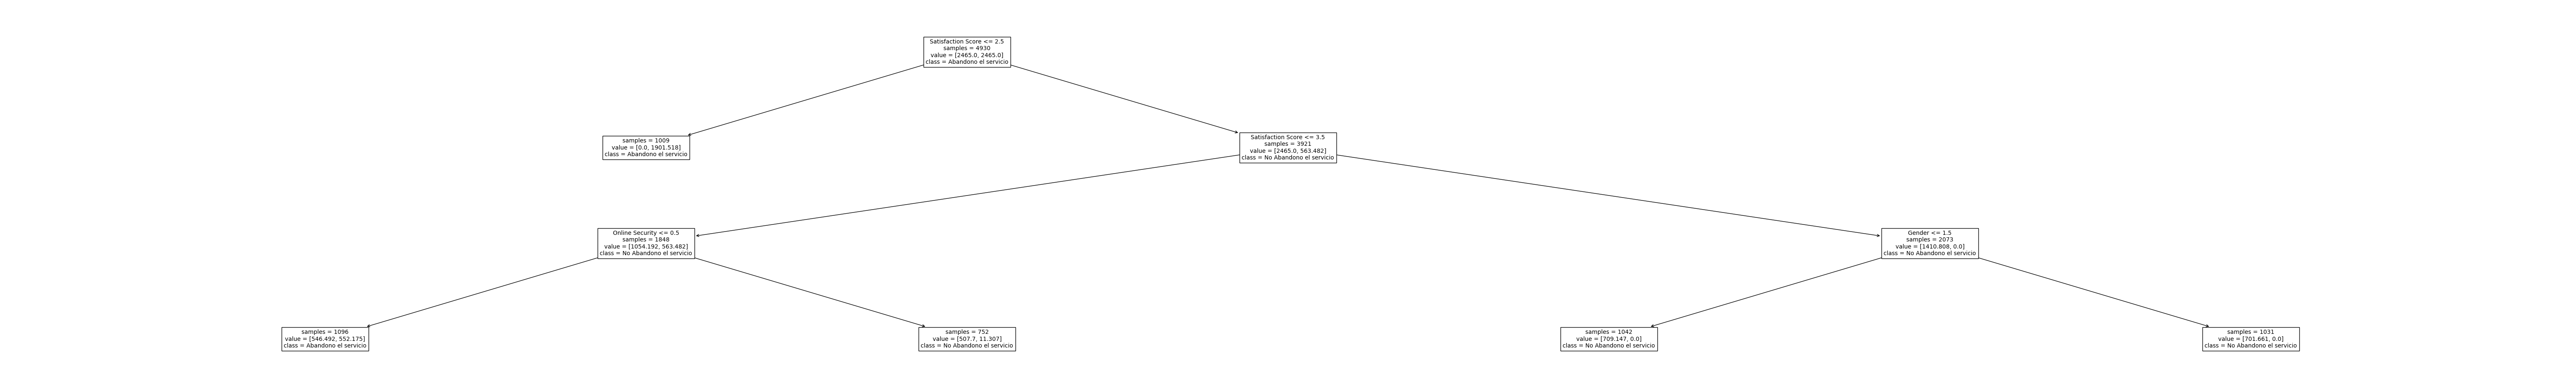

In [108]:
plt.figure(figsize=(80, 12))
plot_tree(
    model1,
    feature_names= columnas_sin_churn, # Changed this line to pass column names
    class_names=["No Abandono el servicio", "Abandono el servicio"],
    label='all',
    impurity=False,
    fontsize=10
)

In [109]:
best_model = tuner.best_estimator_

In [110]:
best_model

DecisionTreeClassifier(min_samples_leaf=10)

In [111]:
tuner.best_params_

{'min_samples_leaf': 10}

In [112]:
search_results = pd.DataFrame(tuner.cv_results_)

In [113]:
search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020290,0.004246,0.003663,0.003104,10,{'min_samples_leaf': 10},0.901961,0.907692,0.924565,0.898833,0.894942,0.905598,0.010360,1
1,0.018032,0.001608,0.004500,0.003015,40,{'min_samples_leaf': 40},0.894531,0.906931,0.921305,0.881633,0.892929,0.899466,0.013548,2
2,0.018855,0.002417,0.001813,0.002410,100,{'min_samples_leaf': 100},0.891089,0.900204,0.909457,0.908722,0.886640,0.899222,0.009170,3
3,0.009979,0.002740,0.002798,0.002957,600,{'min_samples_leaf': 600},0.847682,0.894068,0.892178,0.868251,0.850877,0.870611,0.019678,4


# 6. Model performance evaluation

In [114]:
y_pred1 = best_model.predict(val_data_Cod.drop(columns=["Churn Label"]))
y_pred_prob = best_model.predict_proba(val_data_Cod.drop(columns=["Churn Label"]))[:, 1]

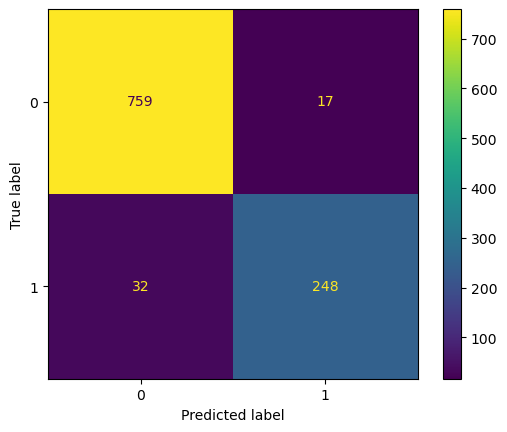

In [115]:
ConfusionMatrixDisplay.from_predictions(y_true=val_data_Cod["Churn Label"], y_pred=y_pred1)

In [116]:
print("Validation Metrics")
print(classification_report(y_true=val_data_Cod["Churn Label"], y_pred=y_pred1))

Validation Metrics
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       776
           1       0.94      0.89      0.91       280

    accuracy                           0.95      1056
   macro avg       0.95      0.93      0.94      1056
weighted avg       0.95      0.95      0.95      1056



# 7. Explainability

In [117]:
explainer = shap.TreeExplainer(best_model, data=train_data_Cod.drop(columns=["Churn Label"]).sample(n=1000, random_state=1), model_output="probability")

In [118]:
explanation = explainer(val_data_Cod.drop(columns=["Churn Label"]))

In [119]:
explanation.shape

(1056, 40, 2)

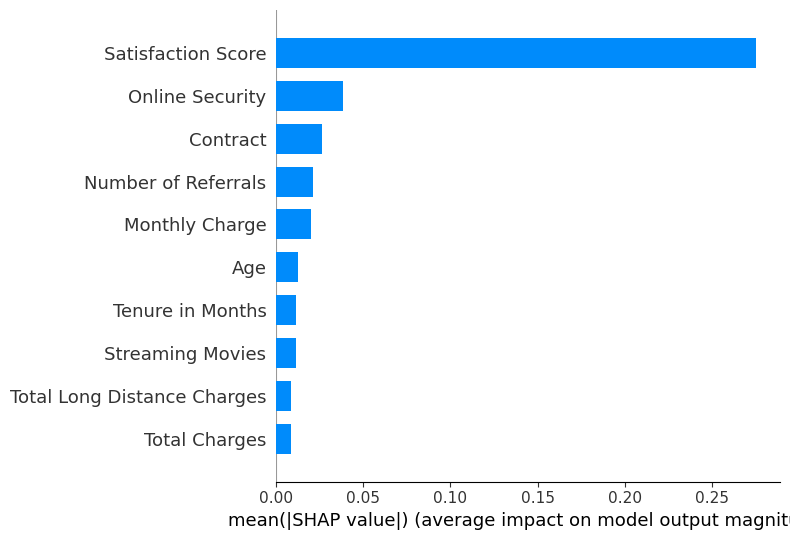

In [120]:
plt.figure(figsize=(20,8))
shap.summary_plot(explanation.values[:,:,1], features=train_data_Cod.drop(columns=["Churn Label"]), plot_type="bar", max_display= 10)

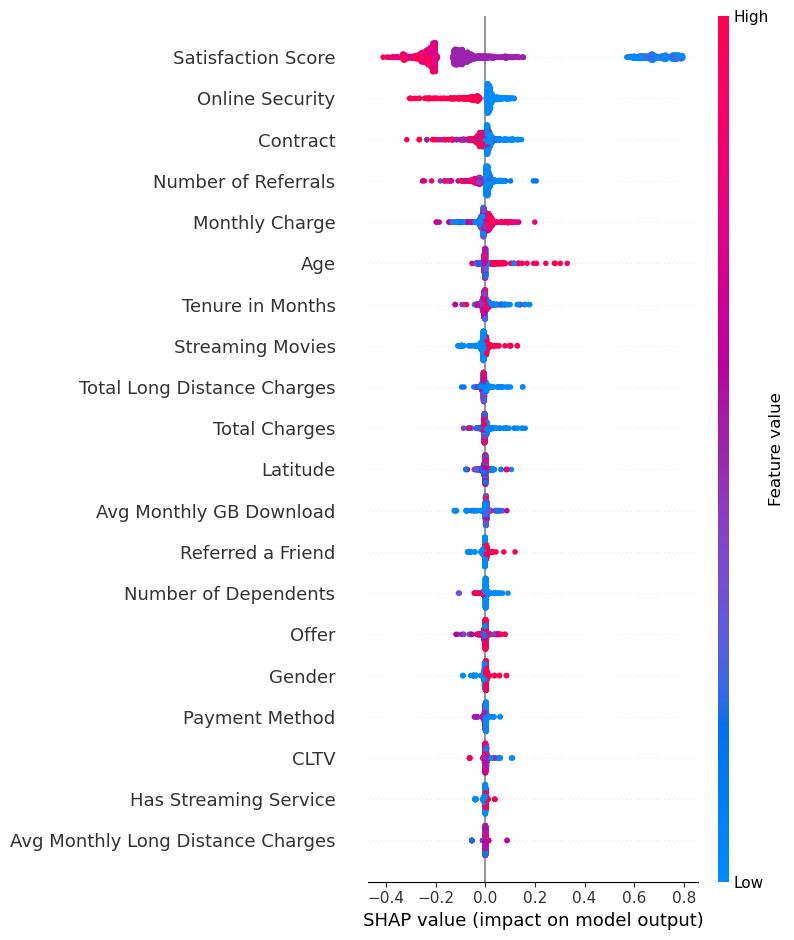

In [121]:
plt.figure(figsize=(20,8))
shap.summary_plot(explanation.values[:,:,1], features=val_data_Cod.drop(columns=["Churn Label"]))

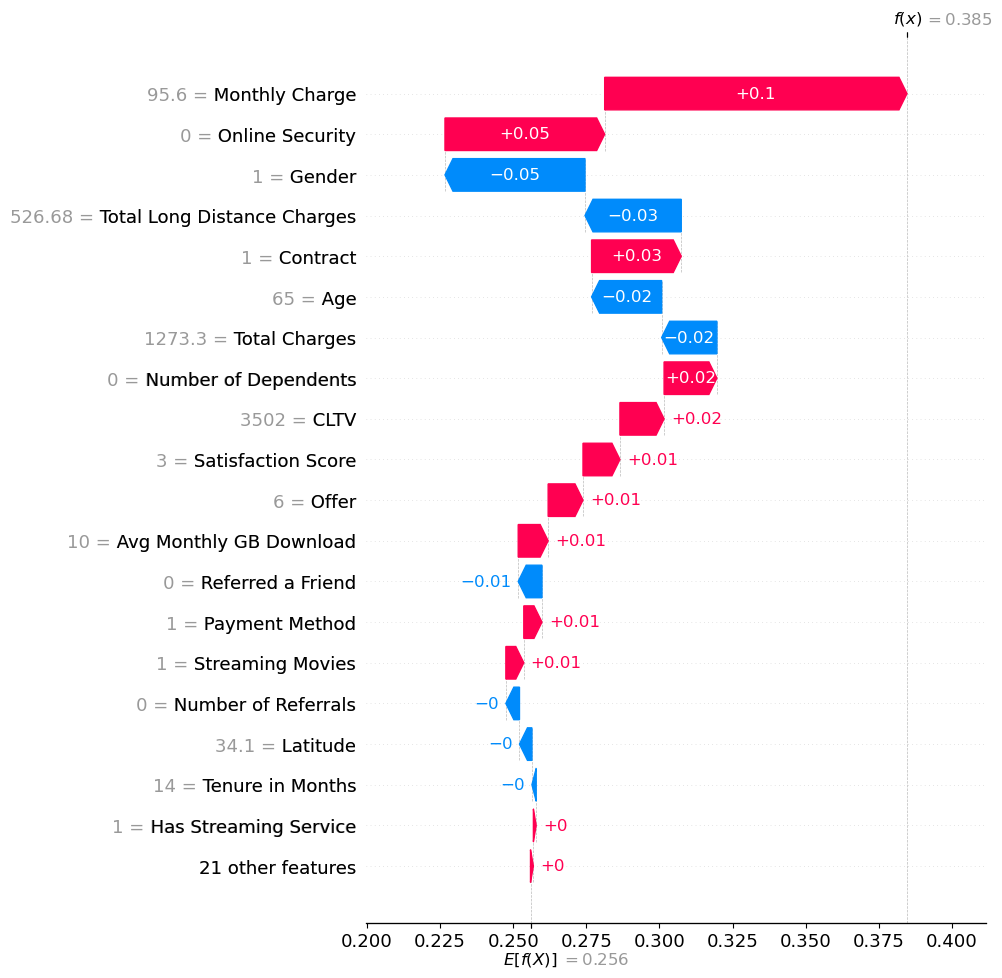

In [122]:
shap.plots.waterfall(explanation[6,:,1], max_display=20)

# MODELO MEJORADO

Vamos hacer un modelo mejorado solo con las variables más relevantes que nos dio la grafica de Shap.

In [123]:
train_dataMejorada= train_data_Cod.copy()

In [124]:
modelMejorado = DecisionTreeClassifier(random_state=1, max_depth=5,min_samples_leaf= 10, class_weight= "balanced")

In [125]:
modelMejorado.fit(X=train_dataMejorada[['Satisfaction Score','Has Streaming Service','Age',
                                        'Contract','Online Security',"Monthly Charge","Number of Referrals","Tenure in Months","Total Charges","Streaming Movies","Total Long Distance Charges"]], y=train_dataMejorada["Churn Label"])

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, random_state=1)

In [126]:
features_ModeloMejorado = ['Satisfaction Score','Has Streaming Service','Age',
                                        'Contract','Online Security',"Monthly Charge","Number of Referrals","Tenure in Months","Total Charges","Streaming Movies","Total Long Distance Charges"]

[Text(0.609375, 0.9166666666666666, 'Satisfaction Score <= 2.5\nsamples = 4930\nvalue = [2465.0, 2465.0]\nclass = Abandono el servicio'),
 Text(0.546875, 0.75, 'samples = 1009\nvalue = [0.0, 1901.518]\nclass = Abandono el servicio'),
 Text(0.671875, 0.75, 'Satisfaction Score <= 3.5\nsamples = 3921\nvalue = [2465.0, 563.482]\nclass = No Abandono el servicio'),
 Text(0.46875, 0.5833333333333334, 'Online Security <= 0.5\nsamples = 1848\nvalue = [1054.192, 563.482]\nclass = No Abandono el servicio'),
 Text(0.25, 0.4166666666666667, 'Contract <= 1.5\nsamples = 1096\nvalue = [546.492, 552.175]\nclass = Abandono el servicio'),
 Text(0.125, 0.25, 'Number of Referrals <= 2.5\nsamples = 608\nvalue = [245.683, 465.485]\nclass = Abandono el servicio'),
 Text(0.0625, 0.08333333333333333, 'samples = 523\nvalue = [190.558, 457.947]\nclass = Abandono el servicio'),
 Text(0.1875, 0.08333333333333333, 'samples = 85\nvalue = [55.126, 7.538]\nclass = No Abandono el servicio'),
 Text(0.375, 0.25, 'Streamin

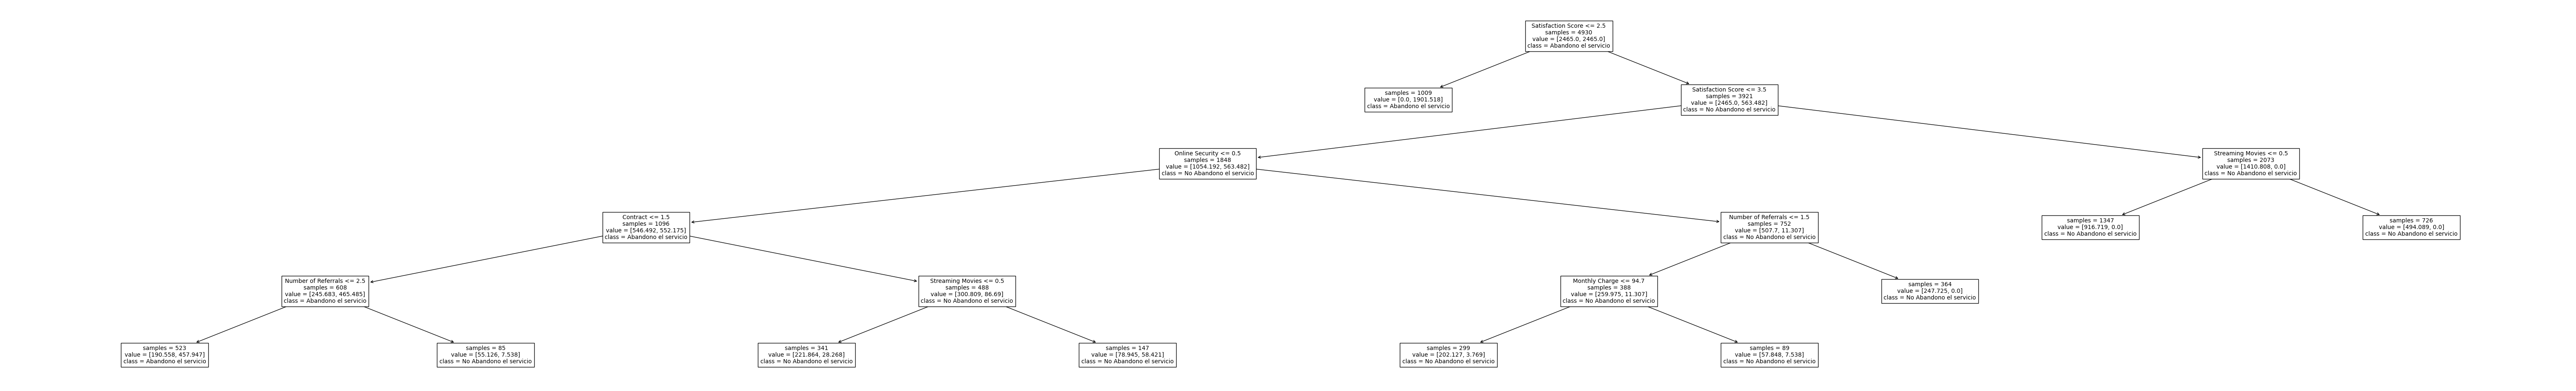

In [127]:
plt.figure(figsize=(80, 12))
plot_tree(
    modelMejorado,
    feature_names= features_ModeloMejorado, # Changed this line to pass column names
    class_names=["No Abandono el servicio", "Abandono el servicio"],
    label='all',
    impurity=False,
    fontsize=10
)

Se priorizo optimizar la metrica de recall porque se busco disminuir los FN para que el modelo pudiese detectar mejor aquellos perfiles de clientes que abandonaban a la compañia.

In [128]:
import xgboost as xgb

scale_pos_weight = 9

params_grid = {
"n_estimators": [20, 50, 100],
"max_depth": [3, 10, 50, 100],
"subsample": [0.3, 0.6, 0.9],
"colsample_bytree": [0.3, 0.6, 0.9],
"colsample_bynode": [0.3, 0.6, 0.9]
}

tuner_round2 = GridSearchCV(
estimator=xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=1),
param_grid=params_grid,
scoring="recall",
return_train_score=True,
n_jobs=-1,
verbose=2
)

In [129]:
tuner_round2.fit(X=train_dataMejorada[features_ModeloMejorado], y=train_dataMejorada["Churn Label"])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'colsample_bynode': [0.3, 0.6, 0.9],
                         'colsample_bytree': [0.3, 0.6, 0.9],
                         'max_depth': [3, 10, 50, 100],
                         'n_estimators': [20, 50, 100],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='recall', verbose=2)

In [130]:
tuner2_best_model = tuner_round2.best_estimator_

In [131]:
val_dataMejorada= val_data_Cod.copy()

In [132]:
pred_train = (tuner2_best_model.predict_proba(train_dataMejorada[features_ModeloMejorado])[:,1] > 0.4).astype("int")
pred_val = (tuner2_best_model.predict_proba(val_dataMejorada[features_ModeloMejorado])[:,1] > 0.4).astype("int")

In [133]:
print("Training metrics (cutoff-point): 0.4")
print(classification_report(y_true=train_dataMejorada["Churn Label"], y_pred=pred_train))

Training metrics (cutoff-point): 0.4
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3622
           1       0.69      0.99      0.82      1308

    accuracy                           0.88      4930
   macro avg       0.84      0.92      0.86      4930
weighted avg       0.92      0.88      0.89      4930



In [134]:
print("Training metrics")
print(classification_report(y_true=train_dataMejorada["Churn Label"], y_pred=pred_train))

Training metrics
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3622
           1       0.69      0.99      0.82      1308

    accuracy                           0.88      4930
   macro avg       0.84      0.92      0.86      4930
weighted avg       0.92      0.88      0.89      4930



# TESTING

Test Metrics
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       776
           1       0.83      0.95      0.89       281

    accuracy                           0.94      1057
   macro avg       0.91      0.94      0.92      1057
weighted avg       0.94      0.94      0.94      1057



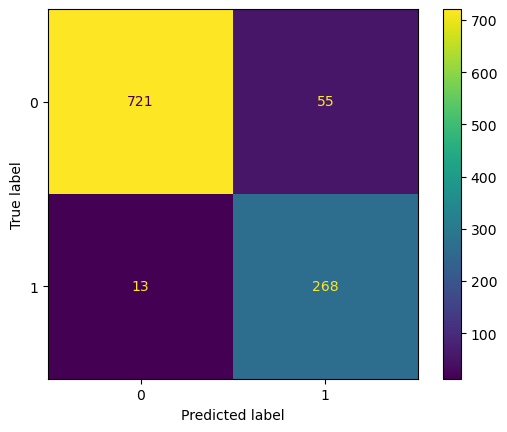

In [135]:
# Realizar predicciones con el modelo mejorado
test_dataMejorada= test_data_Cod.copy()
y_pred2 = modelMejorado.predict(test_dataMejorada[features_ModeloMejorado])
y_pred_prob2 = modelMejorado.predict_proba(test_dataMejorada[features_ModeloMejorado])[:, 1]

# Mostrar la matriz de confusión
confusionMatrix= ConfusionMatrixDisplay.from_predictions(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2) # Changed y_pred to y_pred1

# Imprimir el informe de clasificación (classification report)
print("Test Metrics")
print(classification_report(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2)) # Changed y_pred to y_pred1

specificity = recall_score(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2, pos_label=0)

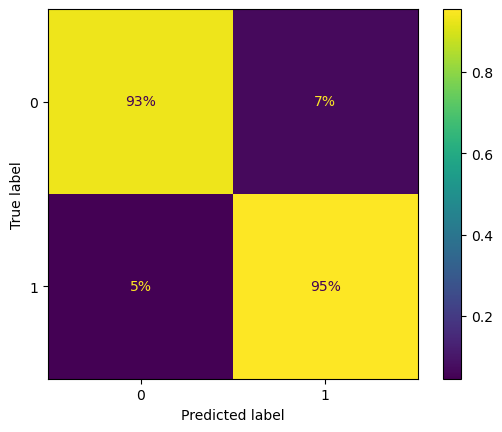

In [136]:
#Calcular la matriz de confusión y normalizar los valores a porcentajes
conf_matrixCantidadCliente = confusion_matrix(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2)
conf_matrixporcentaje = confusion_matrix(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2, normalize= 'true') # Changed "True" to 'true'


#Mostrar la matriz de confusión con los valores en porcentaje
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrixporcentaje, display_labels=modelMejorado.classes_)
disp.plot(values_format=".0%")  # Formato de porcentaje

In [137]:
specificity

0.9291237113402062

Según Evan Bailyn de First Page Sage una consultora especializada en marketing y análisis de adquisición de clientes en distintas industrias.En el sector de telecomunicaciones, el costo promedio de adquisición de clientes (CAC) es de aproximadamente $694 USD

In [138]:
test_dataMejorada["Prediction"] = y_pred2
nclass=test_dataMejorada["CLTV"][test_dataMejorada["Prediction"] == 0].sum()
nclass

3321464

In [139]:
vcP=conf_matrixporcentaje.flatten( )
vcC=conf_matrixCantidadCliente.flatten( )
tn=vcP[0]*nclass
fp=vcC[1]*(694)
fn=vcP[2]*nclass
tp=vcC[3]*(694)

#matriz de confusion con esos valores
cm = np.array([[tn, fp],
              [fn, tp]])



<Figure size 600x400 with 0 Axes>

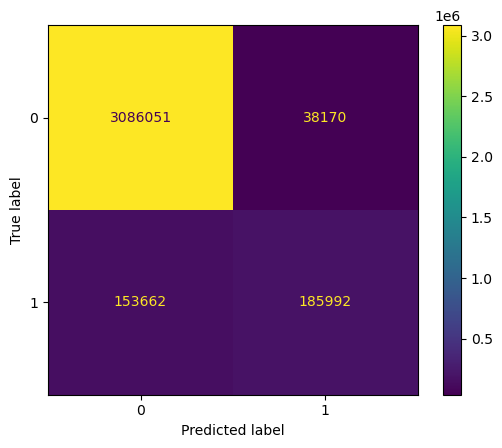

In [140]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelMejorado.classes_)
plt.figure(figsize=(6, 4))
disp.plot(values_format="0.0f")

In [141]:
# Calcular NPV (Negative Predictive Value)
cm = confusion_matrix(y_true=test_dataMejorada["Churn Label"], y_pred=y_pred2)
TN, FP, FN, TP = cm.ravel()
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"NPV (Valor Predictivo Negativo): {NPV:.2f}")

NPV (Valor Predictivo Negativo): 0.98


In [142]:
explainer = shap.TreeExplainer(
    tuner2_best_model,
    data=train_data_Cod[features_ModeloMejorado].sample(n=1000, random_state=1),
    model_output="probability"
)

In [143]:
test_explanation = explainer(test_data_Cod[features_ModeloMejorado])

In [144]:
test_explanation.shape

(1057, 11)

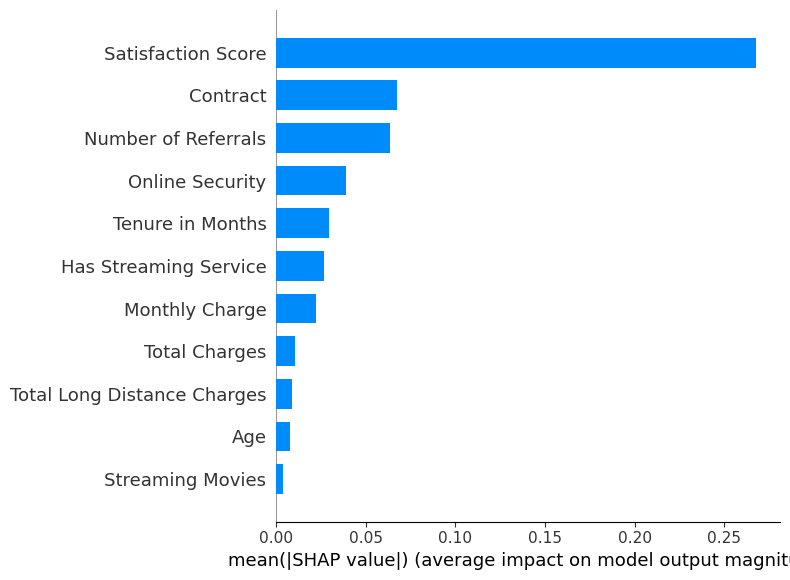

In [145]:
plt.figure(figsize=(20,8))
shap.summary_plot(test_explanation.values, features=test_data_Cod[features_ModeloMejorado], plot_type="bar", max_display=31)

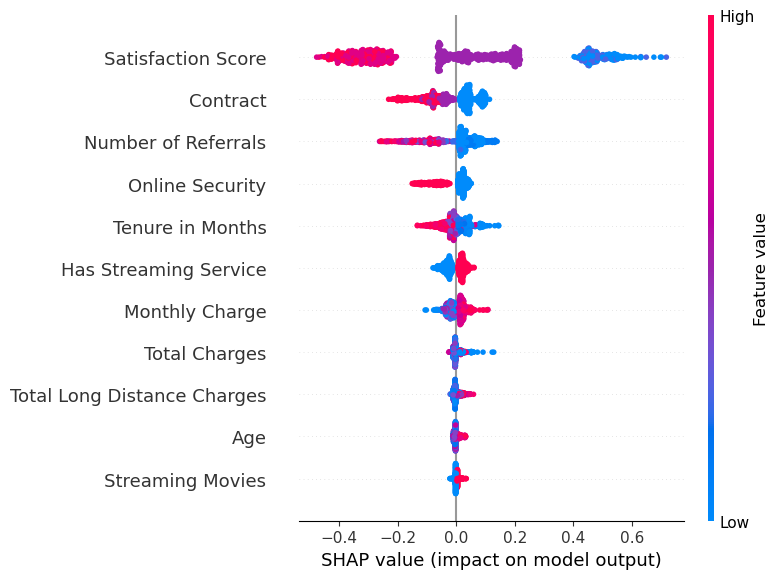

In [146]:
plt.figure(figsize=(20,8))
shap.summary_plot(test_explanation.values, features=test_data_Cod[features_ModeloMejorado])

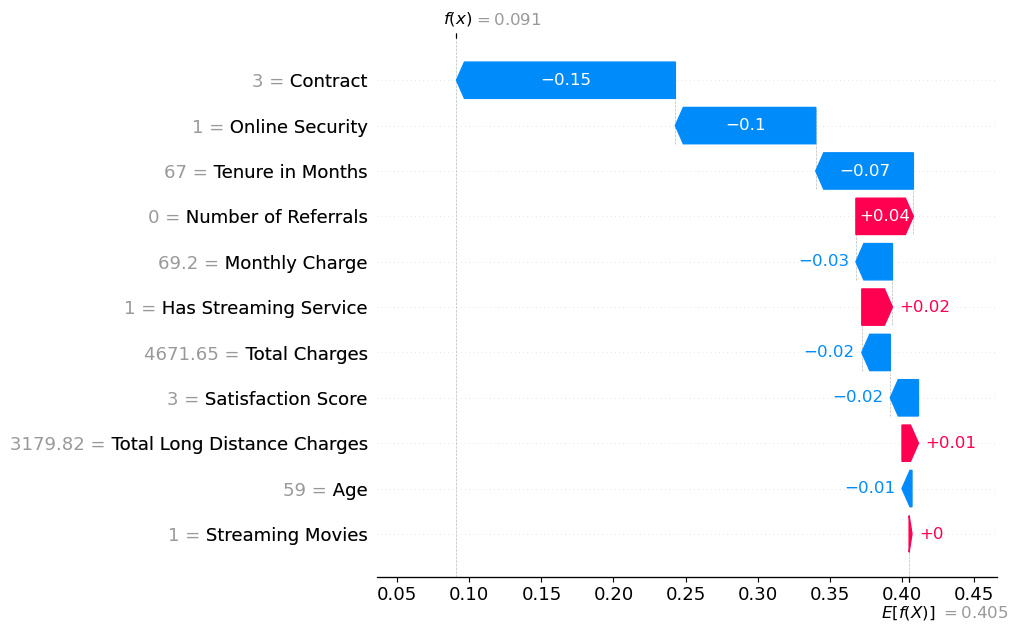

In [147]:
shap.plots.waterfall(test_explanation[5], max_display=20) # Select a single row to plot